# Madogram Analysis of Synthetic Interfaces

Madogram (the plot of $\gamma$ against lag,  $k$) analysis of:

* Artifical interfaces
* ZOMBIE migrated versions of the interfaces

*This is just to see what it looks like and will probably not be considered further.*

*Semi-variogram oos one of the four methods used to measure the fractal dimension/Hurst exponent of fractal profiles in Gallant et al.*

**Chris Field May 2022**

In [1]:
import os  # operating system
import sys # to add src directory for my modules
#
import numpy as np
import math
import random
#
#
import pandas as pd
#
#
from scipy import stats
from scipy import signal
from scipy.interpolate import interp1d
#
from skimage.io import imread, imsave
#
from datetime import datetime
#
# Plotting requirements
import matplotlib.pyplot as plt
import matplotlib.font_manager # different fonts
from matplotlib import rcParams # runtime config to set fonts

In [2]:
# Using rcParams set the global fonts for Matplotlib
# Global parameters for Matplotlib: set font etc.
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']
rcParams['font.serif'] = ['Garamond']
rcParams['font.size'] = '16'
#

## Define Functions

In [3]:
# Shared variables:
colours = ['#1f77b4', '#ED1D24', '#1CEDAB', '#AC5678', '#896E2E']

In [4]:
def single_plot(samp_sum_list, D_total=50, title='Samp_sum_list', step = 1):
    """
    Plot a list or array, e.g. final samp_sum_list
    
    samp_sum_list -- running sum along the spatial grid of samples, this is our random interface
    D_total -- maximum depth to plot for the random interface plot
    step -- scale the x-axis (by default we assume steps of 1 metre)
    """
    x_init = np.arange(len(samp_sum_list)) 
    x = x_init * step
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Depth (m)')
    
    ax.step(x, samp_sum_list, linewidth=2.5, alpha=0.9, color='#d62728')
    ax.set_ylim([0,D_total])
    plt.gca().invert_yaxis()

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    # ax.tick_params(bottom=False, left=False)

    ## Add bar lines as a horizontal grid.
    # ax.yaxis.grid(color='white')

    plt.tight_layout()
    
    plt.show()

In [5]:
def madogram(samples):
    """
    Return the madogram of a timeseries, as defined in Turcotte 1997
    Input:
    samples -- the timeseries, a list or NumPy array of numbers
    """
    length = len(samples)
    gamma = []
    
    for k in range(length-1):
        # Do the summation over values separated by k
        sumk = 0
        for i in range(length-k):
            diff = int(samples[i+k]) - int(samples[i])
            sumk += abs(diff)

        gamma_k = (1/(2*(length-k)))*sumk
        # Add this to our gamma list
        gamma.append(gamma_k)
        
    return gamma

In [6]:
def restrict_quarter(gamma):
    """
    Restrict list or array (typically madogram) to the first quarter (rounded up):
    "it is common practice to restrict the range to 1/4 of the length of that data" Gallant et al. 1994
    
    Return the madogram of a timeseries, as defined in Turcotte 1997
    
    Input:
    gamma -- the (madogram) timeseries, a list or NumPy array of numbers
    
    Output:
    gamma_trunc -- truncated (madogram) timeseries, a list or NumPy array of numbers
    """
    length = len(gamma)
    new_length = math.ceil(length/4)
    gamma_trunc = gamma[:new_length]
        
    return gamma_trunc

In [7]:
def gamma_plot(gamma, start=1, title='Madogram', step = 1, file_out=False, location='./Plot/'):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- intended to be the madogram, a list
    start -- start from lag start, int
    """
    gamm_trun = gamma[start:]
    x_init = np.arange(len(gamm_trun)) 
    x = x_init * step
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Separation (m)')
    ax.set_ylabel('madogram')
    
    ax.plot(x, gamm_trun, alpha =0.6, color='#1f77b4', solid_capstyle="butt", lw=3)

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.tight_layout()
    
    plt.show()
    
    if file_out:
        fig_name=location + title.replace(" ", "_") + '_madogram'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)

In [8]:
def gamma_plot_log(gamma, start=1, title='Madogram', step=1):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- intended to be the madogram, a list
    start -- start from lag start, int
    """
    gamm_trun = gamma[start:]
    x_init = np.arange(len(gamm_trun)) 
    x = x_init * step
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Log(Separation)')
    ax.set_ylabel('Log(madogram)')
    
    ax.plot(np.log10(x), np.log10(gamm_trun), alpha =0.6, color='#1f77b4', solid_capstyle="butt", lw=3)

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.tight_layout()
    
    plt.show()

In [9]:
def gamma_log_slope_intercept(gamma, start=0, title='Madogram', step=1, s_der_strt=1, s_der_fin=-1, p=1):
    """
    Return intercept and gradient of variogram regression in log-log space.
    
    gamma -- intended to be the madogram, a list
    start -- start from lag start, int
    title -- title, string
    label_slope -- put the regression slope on the ploy or not, bool
    step -- spatial step size (m),
    s_der_start -- start of regression derivation in log log space (in number of grid points separation)
    s_der_fin -- end of regression derivation in log log space (in number of grid points separation from the end, neg number)
    p = 1 for madograqm, p=2 for variogram calculation of fractal dimension
    """
    gamm_trun = gamma[start:]
    x_init = np.arange(len(gamm_trun)) 
    x = x_init * step
    
    print(f'For {title}:\n')
    
        # Do a regression and work out the slope
    res = stats.linregress(np.log10(x[s_der_strt:s_der_fin]), np.log10(gamm_trun[s_der_strt:s_der_fin]))
    
    res_slope = res.slope
    res_int = res.intercept
    haus = res_slope/p
    frac_dim = 2 - haus
    
    res_slope = round(res_slope, 2)
    res_int = round(res_int, 2)
    haus = round(haus, 2)
    frac_dim =round(frac_dim, 2)
    
    print(f'The slope is {res_slope} and intercept it {res_int}. The fractal dimension is {frac_dim}.')
    print()
    print('################################################')
    # plot

    return res.slope, res.intercept, frac_dim, x, gamm_trun

In [10]:
def gamma_plot_log_slope(gamma, start=1, title='Madogram', label_slope=True, step=1, s_der_strt=1, s_der_fin=-1, file_out=False, location='./Plot/'):
    """
    Plot a list or array, e.g. variogram, in log-log space with derived linear regression
    To just use the first two points for the regressions_der_strt=1, s_der_fin=3
        
    gamma -- intended to be the madogram, a list
    start -- start from lag start, int
    title -- title, string
    label_slope -- put the regression slope on the ploy or not, bool
    step -- spatial step size (m),
    s_der_start -- start of regression derivation in log log space (in number of grid points separation)
                    Note this is from point 1 or parger as 0 (which is no separation) gives -inf,
    s_der_fin -- end of regression derivation in log log space (number of grid points separation from the end as a neg number, or positive counting onwards from the start)
    """
    slope, intercept, frac_dim, x, gamm_trun = gamma_log_slope_intercept(gamma=gamma, start=start, title=title, step=step, s_der_strt=s_der_strt, s_der_fin=s_der_fin)
    
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Log(Separation)')
    ax.set_ylabel('Log(madogram)')
    
    ax.plot(np.log10(x), np.log10(gamm_trun), alpha =0.6, color='#1f77b4', marker='o')
    
        
    label = 'Slope = ' + str(round(slope,2))
    # Bold version over derive area
    ax.plot(np.log10(x[s_der_strt:s_der_fin]), intercept + slope*np.log10(x[s_der_strt:s_der_fin]),  alpha=0.9, color='grey', 
            linewidth=5)
    # Thinner over the rest of the plot
    ax.plot(np.log10(x[1:-1]), intercept + slope*np.log10(x[1:-1]),  alpha=0.8, color='grey', 
        linewidth=2)

    if label_slope:
        ax.text(3, 3.5 , label, color='grey')

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.tight_layout()
    
    plt.show()

    if file_out:
        fig_name=location + title.replace(" ", "_") + '_madogram_loglog'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)
        
    return

In [11]:
def combined_gamma_plot2(df_plot, depth_col='Z', title='Title', step=2, s_der_strt=1, s_der_fin=3, file_out=False, location='./Plot/'):
    """
    Plot the madogram and log-log plot of madogram with derived slope.
    Input:
    df_plot -- input dataframe
    depth_col -- column of dataframe with interface depth values
    title -- title at top of plot (string)
    step -- step of each point laterally in metres
    remove_end -- how much of the end of the log-log plot to remove when deriving slope
    """
    samples = df_plot[depth_col].to_list()
    gamma = madogram(samples)
    gamma_trunc = restrict_quarter(gamma)
    gamma_plot(gamma_trunc, title=title, start=0, step =step, file_out=file_out, location=location)
    print(f'the length of the truncated madogram is {len(gamma_trunc)}')
    gamma_plot_log_slope(gamma_trunc, title=title, start=0, step =step, s_der_strt=s_der_strt, s_der_fin=s_der_fin, file_out=file_out, location=location )

In [12]:
def gamma_list_plot_log(gammas, labels, start=1, title='Madograms', step=1, file_out=False, location='./Plot/', colours = colours):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- list of madogram functions, up to 3 items
    labels -- labels of madogram functions
    start -- start from lag start, int
    """
    colours = colours
    
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Log(Separation)')
    ax.set_ylabel('Log(madogram)')
    
    num_gammas = len(gammas)
    
    for i in range(num_gammas):
        colour = colours[i]
        gamma = gammas[i]
        label = labels[i]
        gamm_trun = gamma[start:]
        x_init = np.arange(len(gamm_trun)) 
        x = x_init * step
        ax.plot(np.log10(x[1:]), np.log10(gamm_trun[1:]), alpha =0.6, color=colour, solid_capstyle="butt", lw=3, label=label)

    ax.legend(loc='best')
        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
    
    plt.show()
    
    
    if file_out:
        fig_name=location + title.replace(" ", "_") + label.replace(" ", "_").replace(".", "_").replace(",", "_") + '_madograms_loglog'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)

In [13]:
def gamma_list_plot(gammas, labels, start=1, title='Madograms', step=1, file_out=False, location='./Plot/', colours=colours):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- list of madogram functions, up to 3 items
    labels -- labels of madogram functions
    start -- start from lag start, int
    """
    colours = colours
    
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Separation (m)')
    ax.set_ylabel('madogram')
    
    num_gammas = len(gammas)
    
    for i in range(num_gammas):
        colour = colours[i]
        gamma = gammas[i]
        label = labels[i]
        gamm_trun = gamma[start:]
        x_init = np.arange(len(gamm_trun)) 
        x = x_init * step
        ax.plot(x, gamm_trun, alpha =0.6, color=colour, solid_capstyle="butt", lw=3, label=label)

    ax.legend(loc='best')
        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
    
    plt.show()
    
    
    if file_out:
        fig_name=location + title.replace(" ", "_") + label.replace(" ", "_").replace(".", "_").replace(",", "_") + '_madograms'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)

# Input Data

In [14]:
location_in = './Input_3/'

location_out='./Output_3/'

location_out_plots='./Pictures/Horizon_analysis_plots/madogram_plots/'

# If necessary make output folders

    
if not os.path.exists(location_out_plots) :
    os.makedirs(location_out_plots)

# madogram Calculations

In [15]:
# Read csv nDI format TBZ (event) ascii
df_input=pd.read_csv(location_in + '220314_ZOMBIE_nDI_XYZ_csv.dat.csv')
# Remove quote marks from column names
df_input.columns=df_input.columns.str.replace('\"','')
# Some column names have trailing white space, remove this
df_input.columns=df_input.columns.str.replace('\s+','')

In [16]:
# Remove column Y (all zeros) and first and last 1.5km (7750 rows)
df_input.drop(['Y'], axis=1, inplace=True)
df_input = df_input.iloc[750:-750]

In [17]:
df_input.head()

,X,Spectral_slope_interface_1p92,Spectral_slope_interface_1p89,Pareto_fault_interface_b_2p0,Pareto_fault_interface_b_1p5,sin1000,const2000,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35,Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35,Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20,Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35,Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20,Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35,Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20,const2000SPIRIT:T0_20,const2000SPIRIT:T0_35,"sin1000SPIRIT:T0_35,1","sin1000SPIRIT:T0_20,1"
750,1500.0,1940.0,1973.0,1923.0,1729.0,2000.0,2000.0,1920.6942,1920.5165,1727.6500,1727.9429,1936.6478,1936.8615,1967.4410,1967.4648,1998.817,1998.6265,1998.6924,1999.1025
751,1502.0,1939.0,1966.0,1923.0,1730.0,1999.0,2000.0,1920.7380,1920.6072,1727.4919,1727.7345,1936.7971,1937.0085,1967.5566,1967.6877,1998.821,1998.6265,1997.4878,1997.9397
752,1504.0,1937.0,1966.0,1921.0,1730.0,1997.0,2000.0,1920.8838,1920.8020,1727.3286,1727.5165,1936.8752,1937.0734,1967.7166,1967.9436,1998.817,1998.6255,1996.2195,1996.6829
753,1506.0,1934.0,1968.0,1920.0,1728.0,1996.0,2000.0,1921.1455,1921.1147,1727.1353,1727.2690,1936.9050,1937.0883,1967.8795,1968.1847,1998.817,1998.6255,1994.9473,1995.4250
754,1508.0,1940.0,1970.0,1919.0,1727.0,1995.0,2000.0,1921.5117,1921.5668,1726.9155,1726.9714,1936.9336,1937.0945,1968.0291,1968.3909,1998.821,1998.6265,1993.6154,1994.1326


In [18]:
data_list = [
 ('Spectral_slope_interface_1p89','Spectral Slope 1.89'), ('Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35', 'Spectral Slope 1.89, Kirchhoff 35 deg mute'), 
 ('Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20', 'Spectral Slope 1.89, Kirchhoff 20 deg mute'), 
 ('Spectral_slope_interface_1p92', 'Spectral Slope 1.92'), ('Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35', 'Spectral Slope 1.92, Kirchhoff 35 deg mute'), 
 ('Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20', 'Spectral Slope 1.92, Kirchhoff 20 deg mute'), 
 ('Pareto_fault_interface_b_2p0', 'Pareto Faulted 2.0'), ('Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35', 'Pareto Faulted 2.0, Kirchhoff 35 deg mute'),
 ('Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20', 'Pareto Faulted 2.0, Kirchhoff 20 deg mute'),
 ('Pareto_fault_interface_b_1p5','Pareto Faulted 1.5'), ('Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35', 'Pareto Faulted 1.5, Kirchhoff 35 deg mute'),
 ('Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20', 'Pareto Faulted 1.5, Kirchhoff 20 deg mute'),
 ('sin1000', 'Sine, Wavelength 1000m'), ('sin1000SPIRIT:T0_35,1', 'Sine, Wavelength 1000m, Kirchhoff 35 deg mute'),
 ('sin1000SPIRIT:T0_20,1', 'Sine, Wavelength 1000m, Kirchhoff 20 deg mute')]

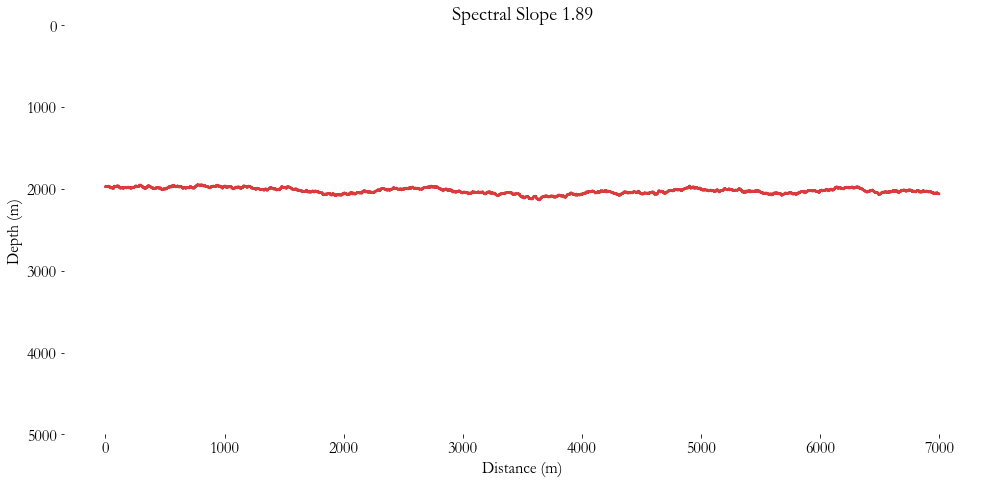

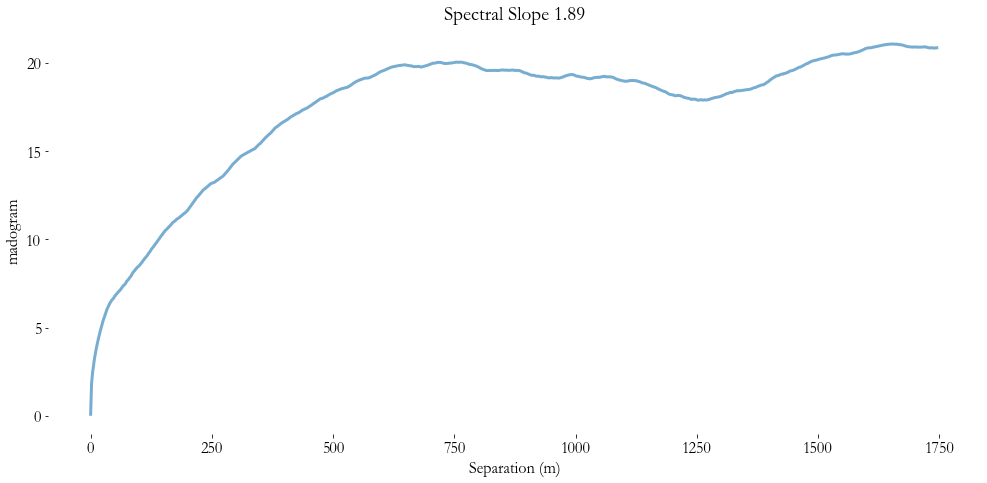

the length of the truncated madogram is 875
For Spectral Slope 1.89:

The slope is 0.42 and intercept it 0.13. The fractal dimension is 1.58.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


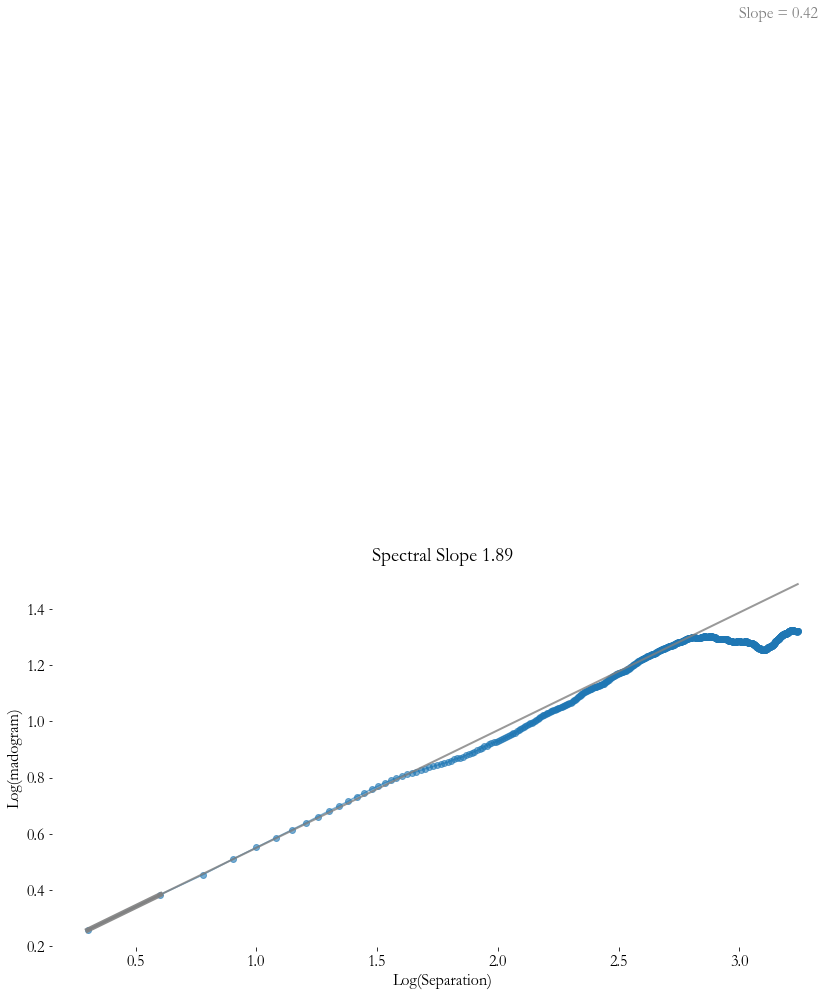

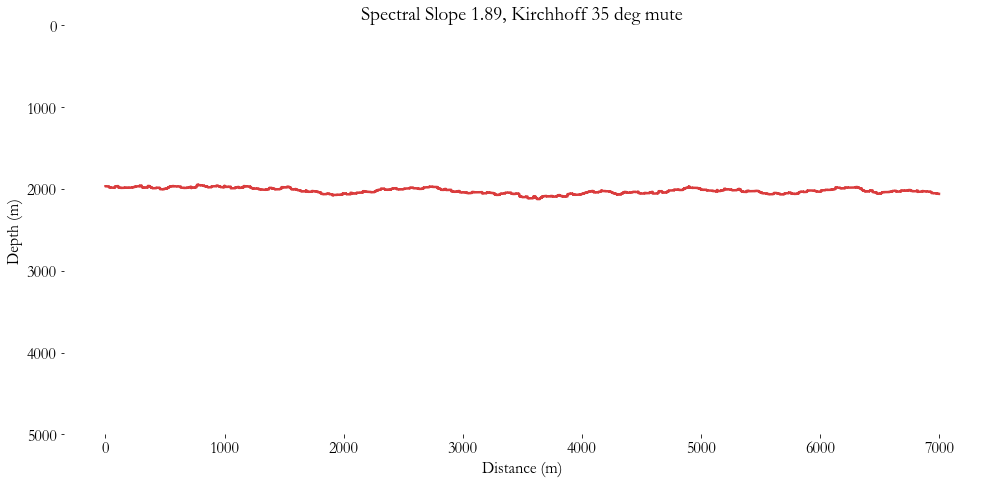

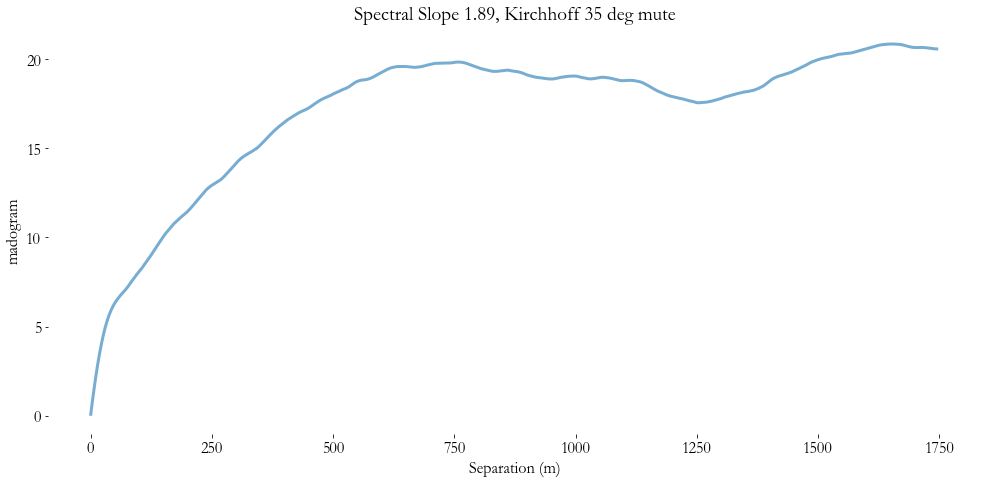

the length of the truncated madogram is 875
For Spectral Slope 1.89, Kirchhoff 35 deg mute:

The slope is 0.97 and intercept it -0.64. The fractal dimension is 1.03.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


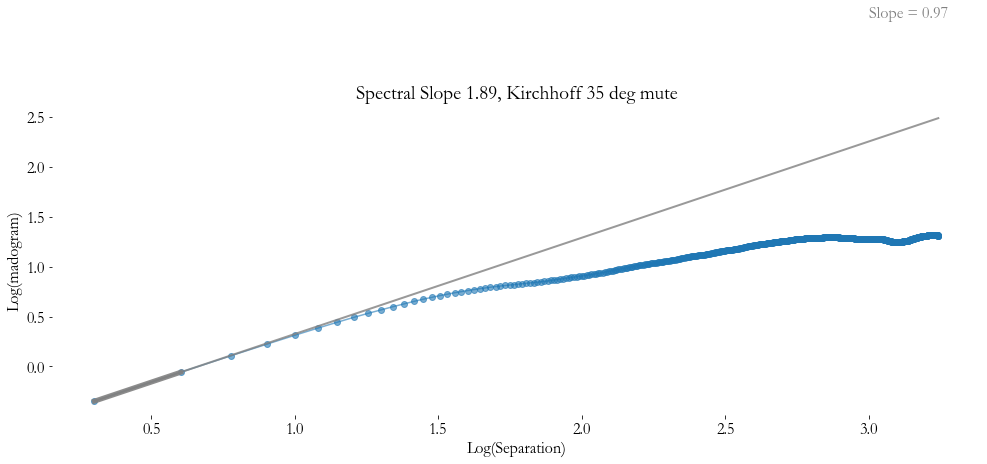

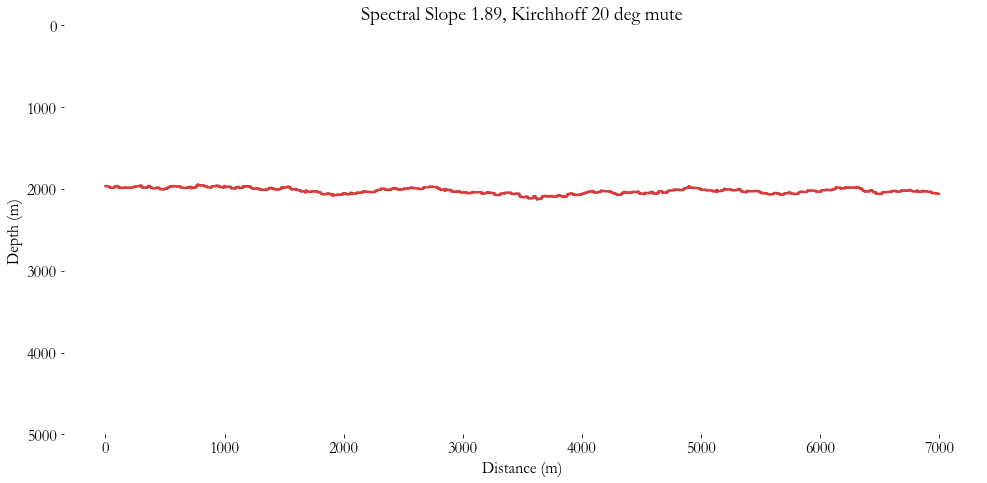

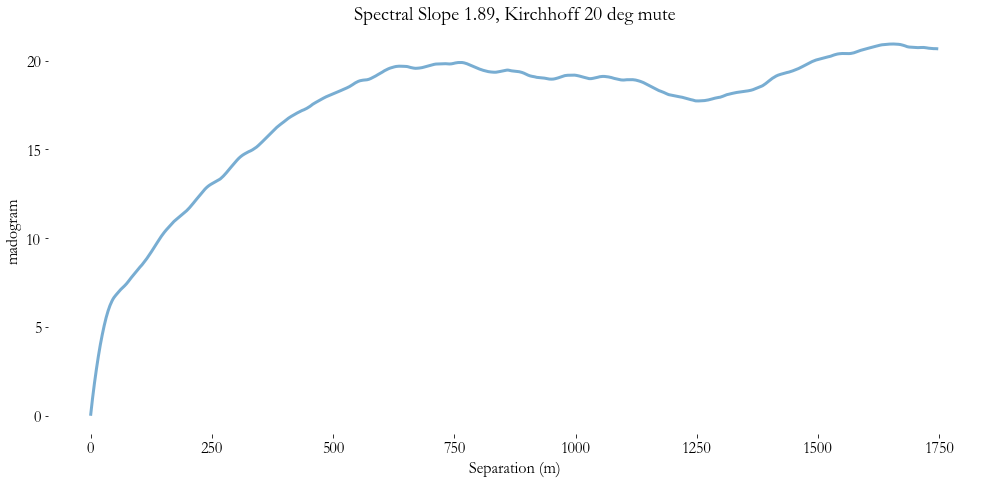

the length of the truncated madogram is 875
For Spectral Slope 1.89, Kirchhoff 20 deg mute:

The slope is 0.94 and intercept it -0.58. The fractal dimension is 1.06.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


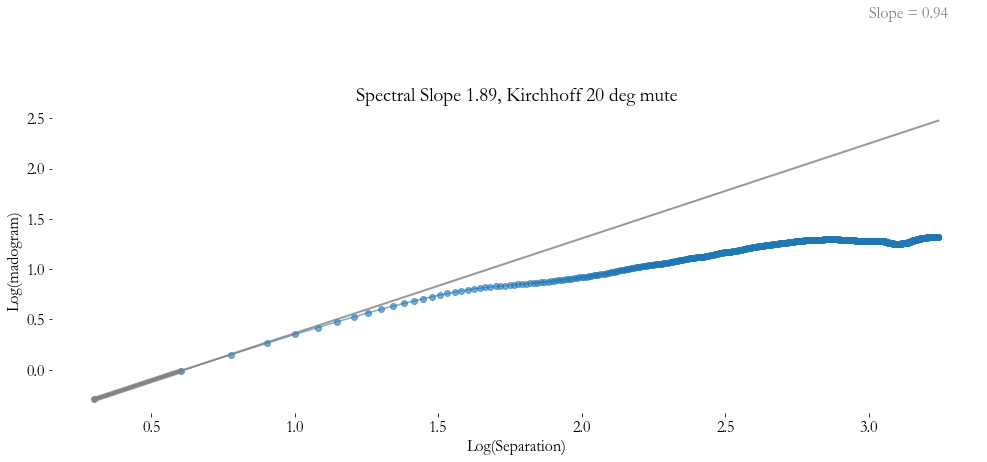

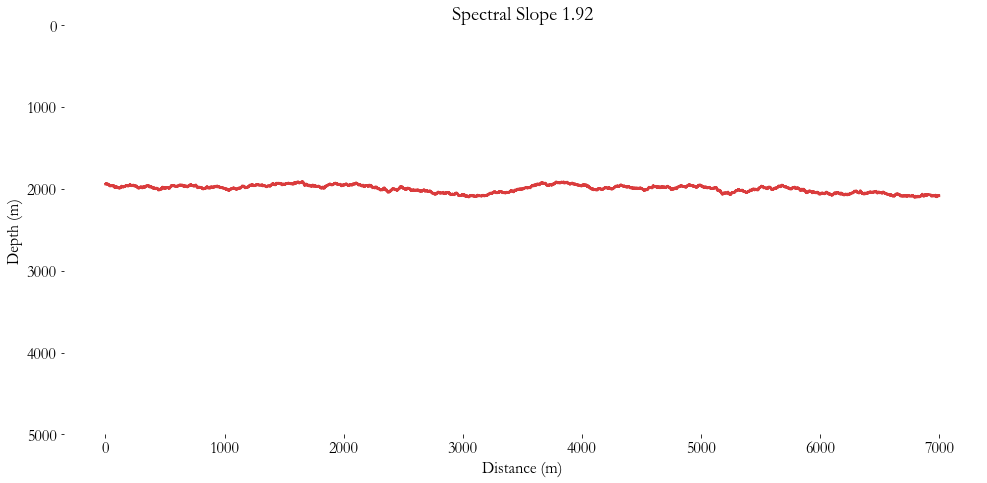

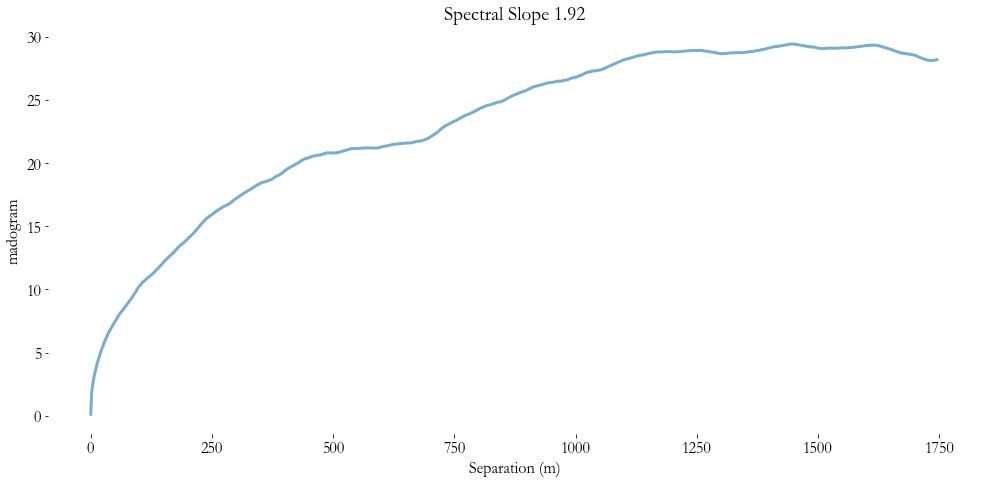

the length of the truncated madogram is 875
For Spectral Slope 1.92:

The slope is 0.41 and intercept it 0.14. The fractal dimension is 1.59.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


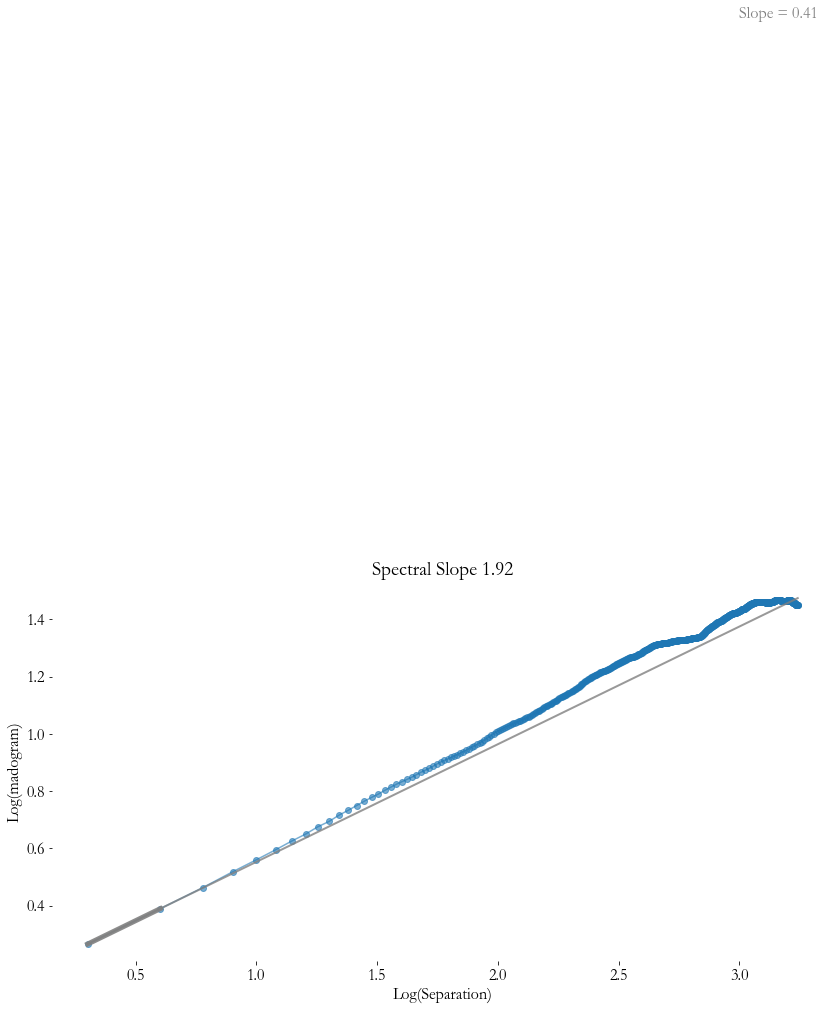

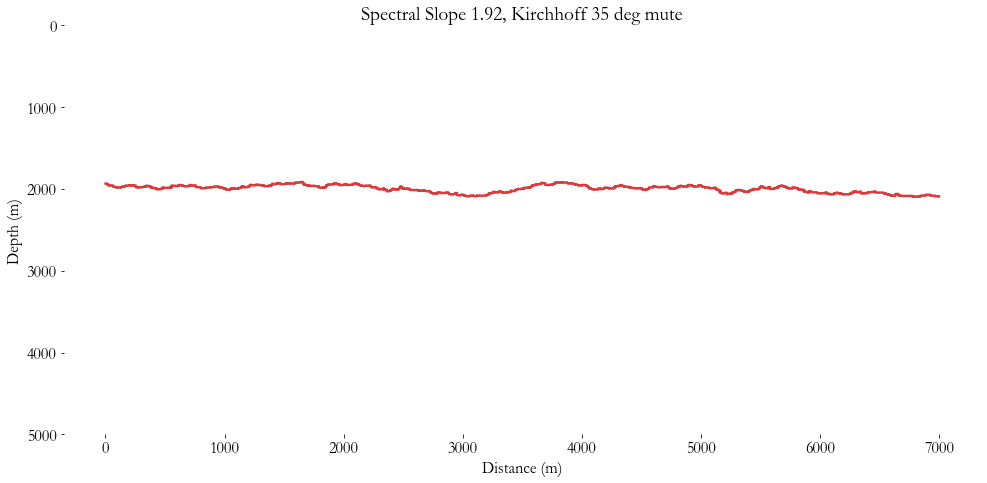

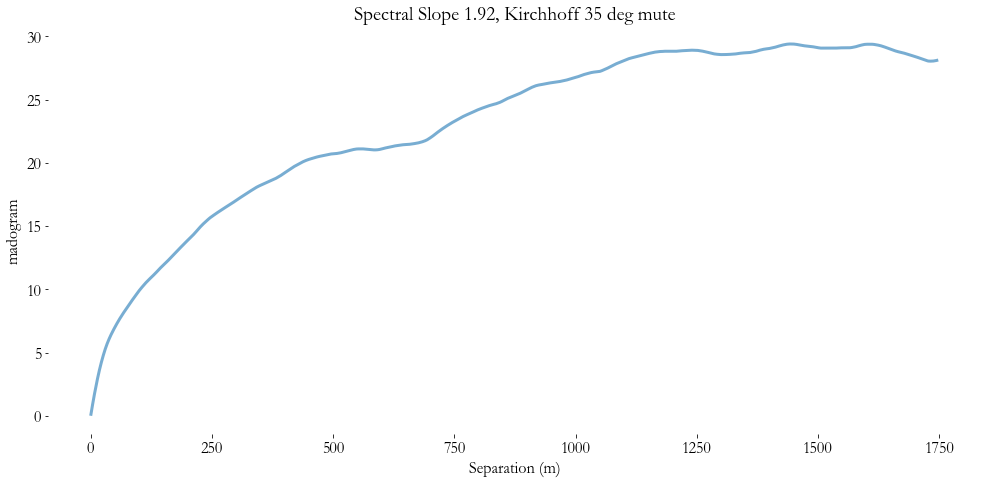

the length of the truncated madogram is 875
For Spectral Slope 1.92, Kirchhoff 35 deg mute:

The slope is 0.95 and intercept it -0.61. The fractal dimension is 1.05.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


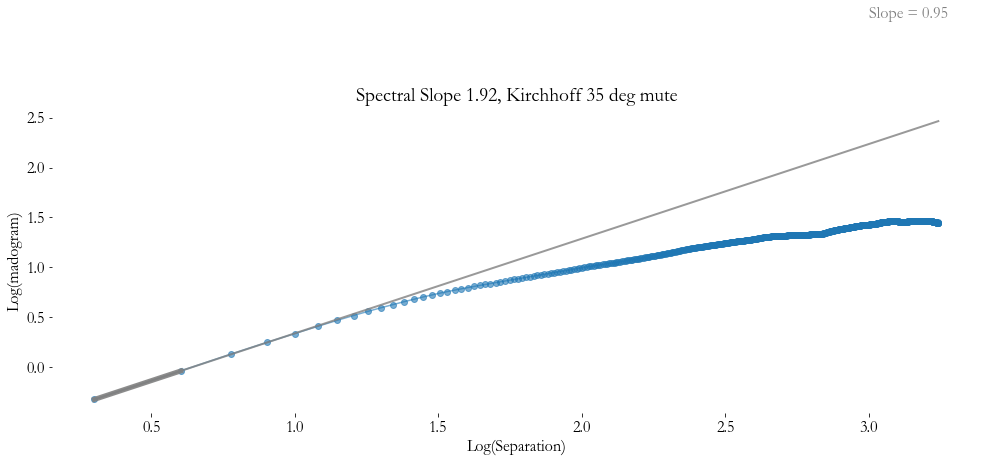

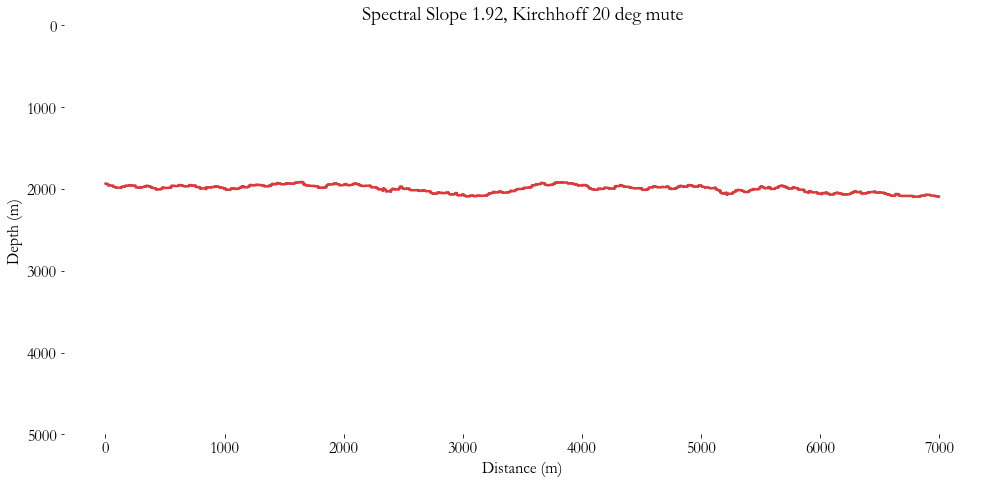

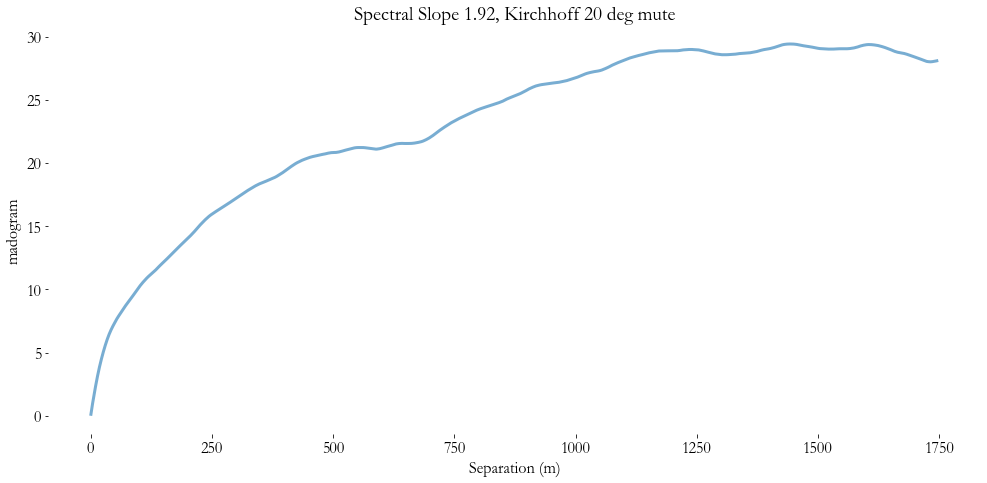

the length of the truncated madogram is 875
For Spectral Slope 1.92, Kirchhoff 20 deg mute:

The slope is 0.94 and intercept it -0.57. The fractal dimension is 1.06.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


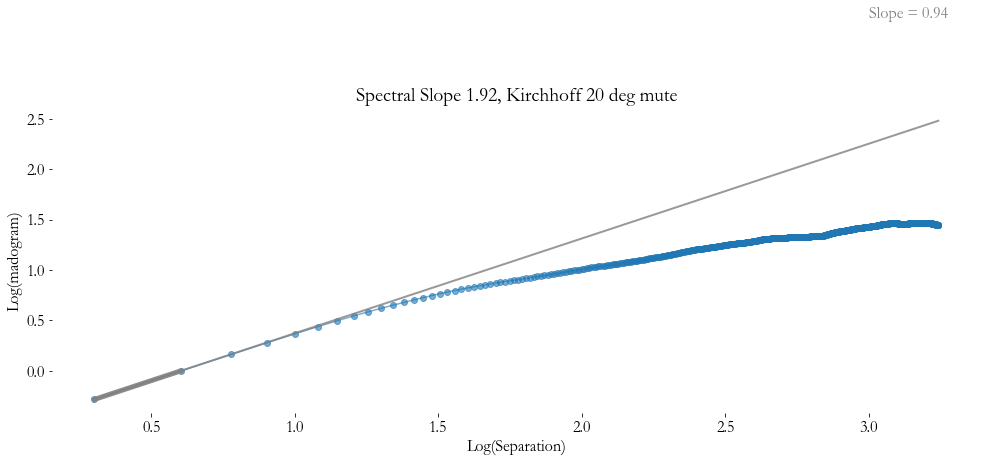

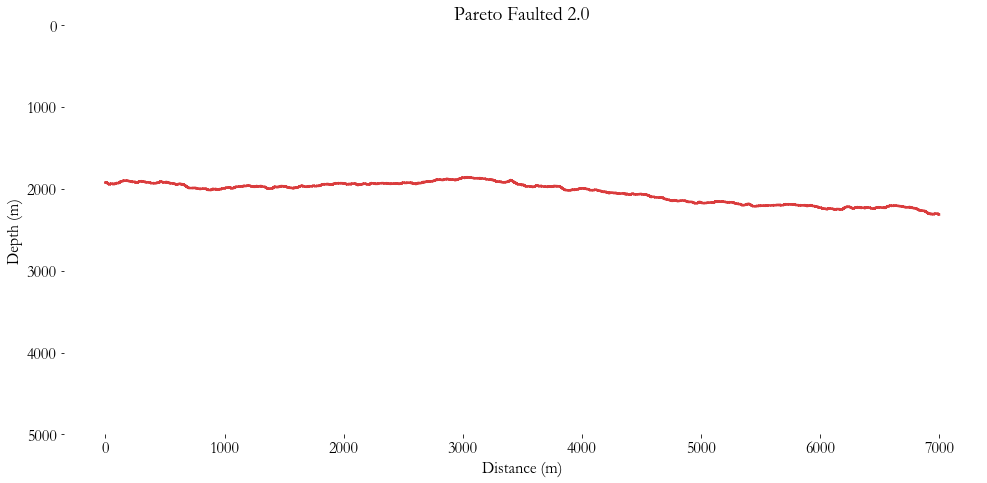

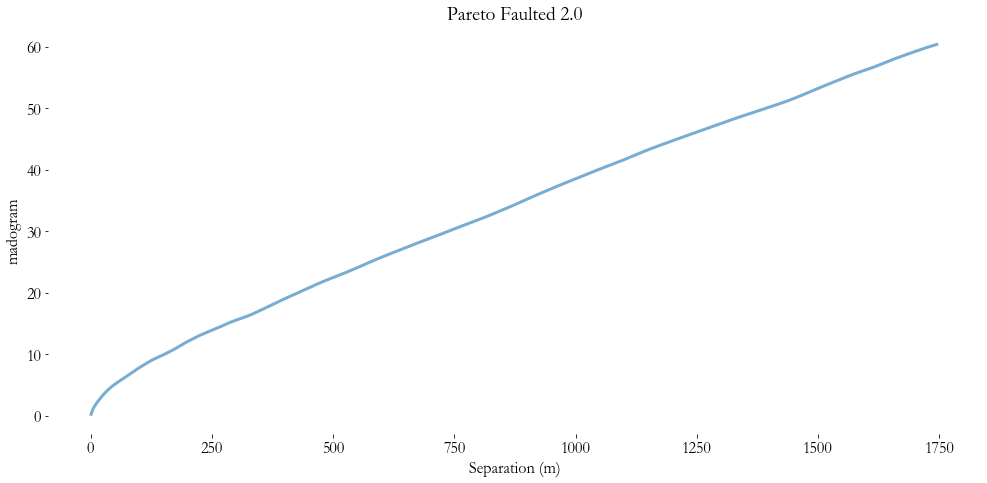

the length of the truncated madogram is 875
For Pareto Faulted 2.0:

The slope is 0.79 and intercept it -0.49. The fractal dimension is 1.21.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


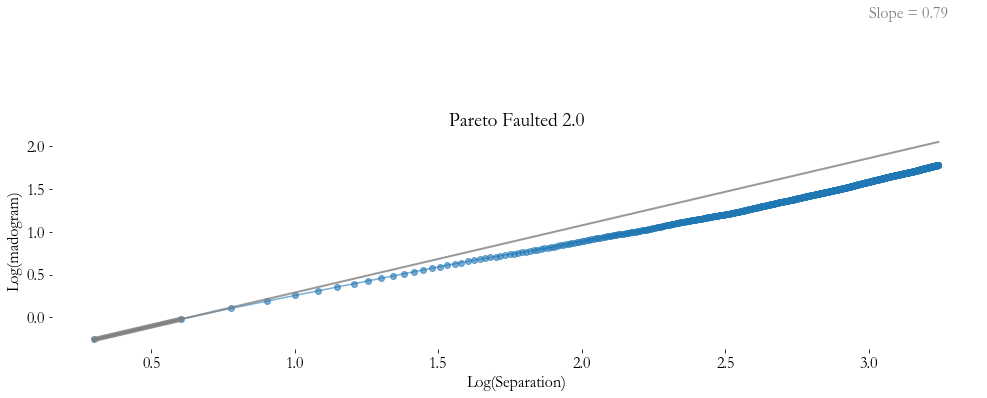

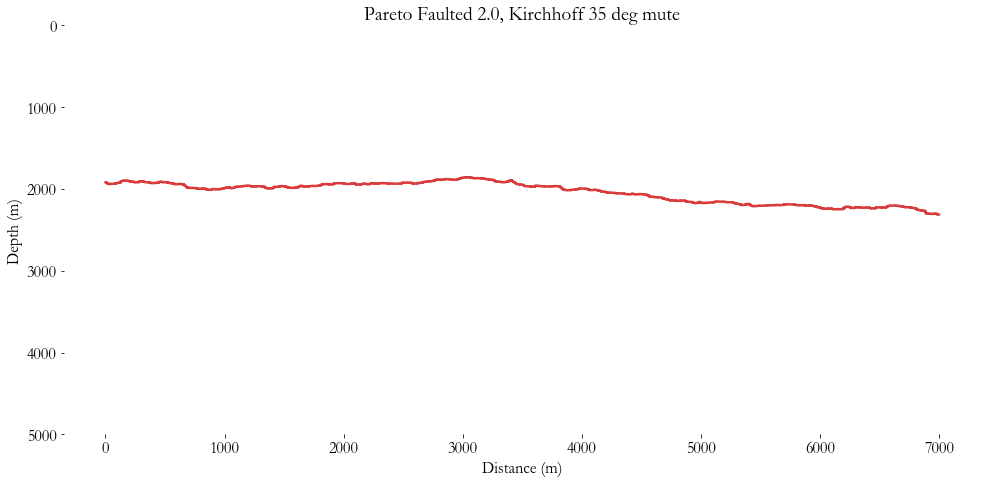

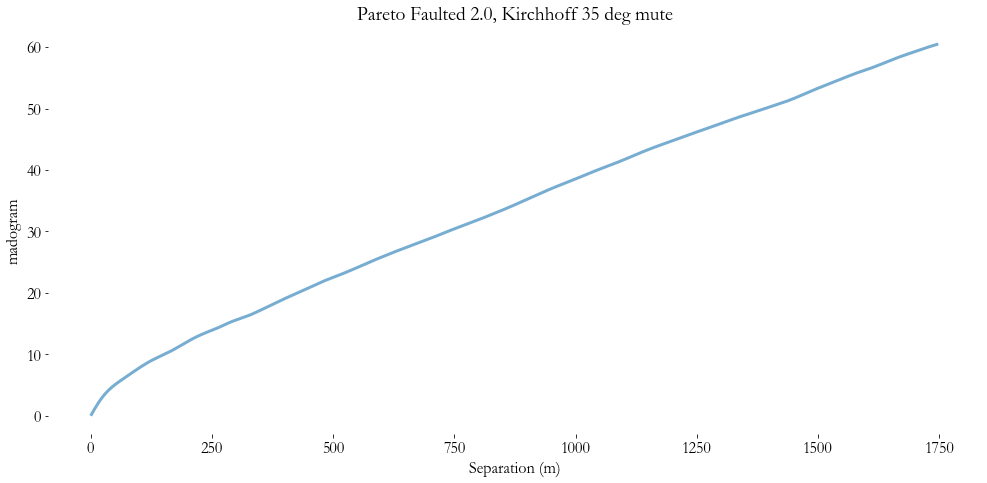

the length of the truncated madogram is 875
For Pareto Faulted 2.0, Kirchhoff 35 deg mute:

The slope is 0.99 and intercept it -0.85. The fractal dimension is 1.01.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


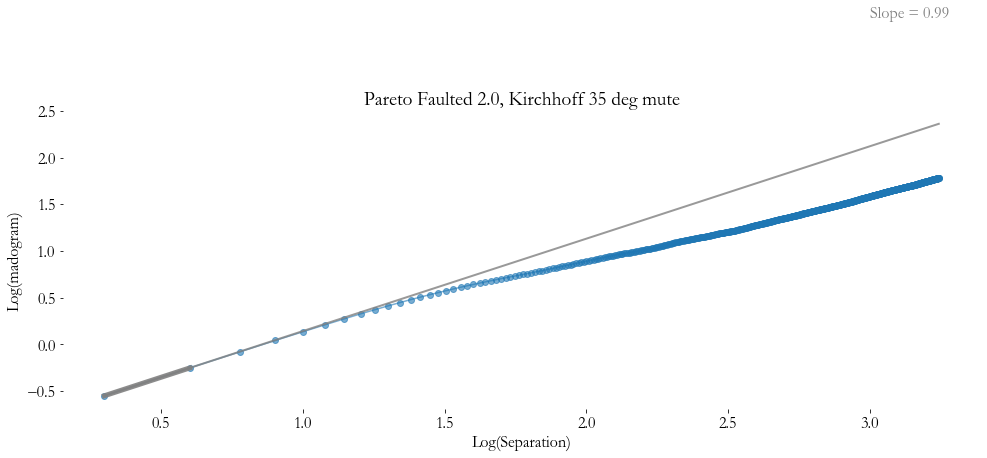

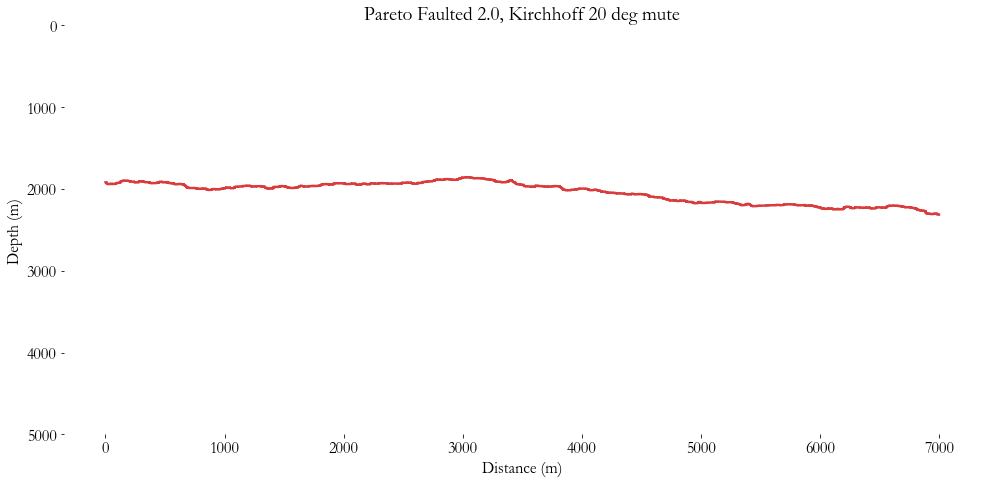

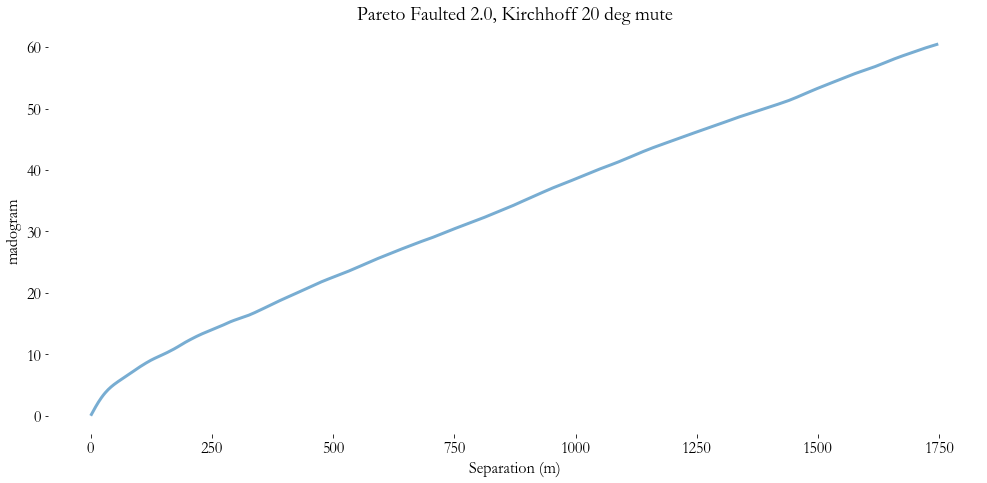

the length of the truncated madogram is 875
For Pareto Faulted 2.0, Kirchhoff 20 deg mute:

The slope is 0.99 and intercept it -0.83. The fractal dimension is 1.01.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


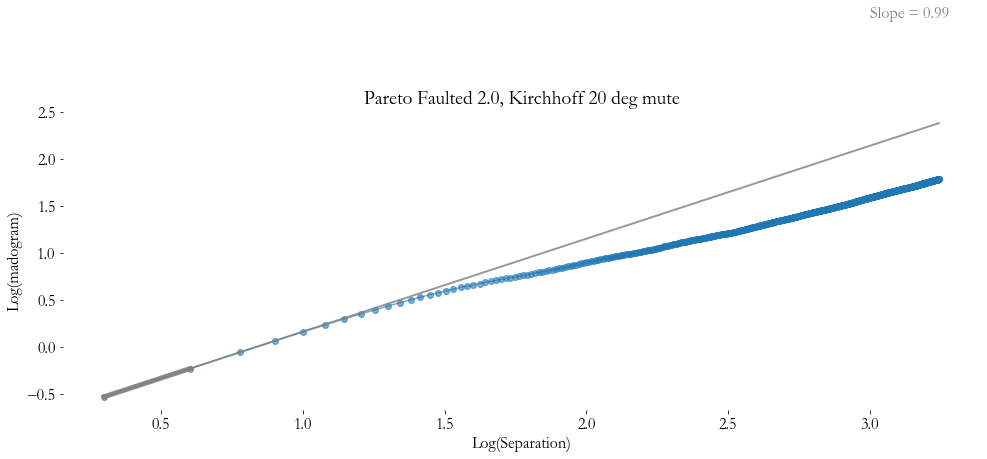

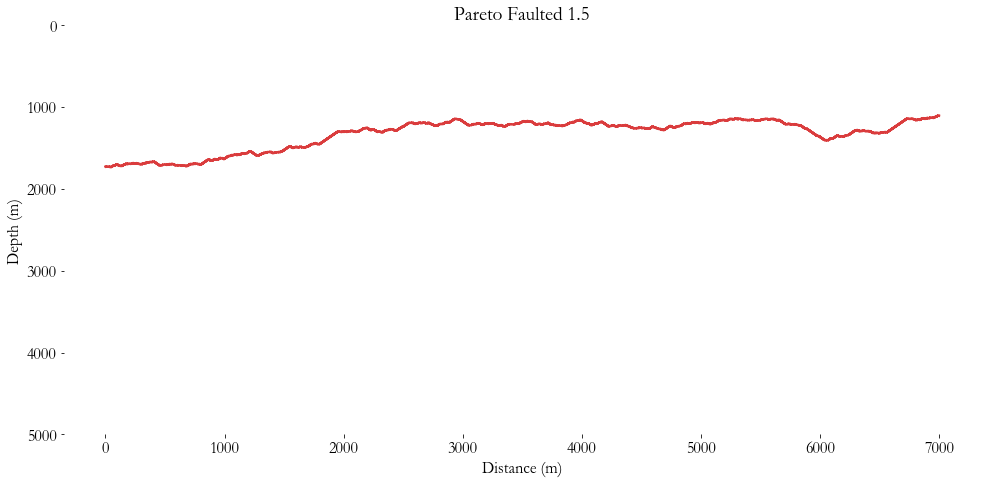

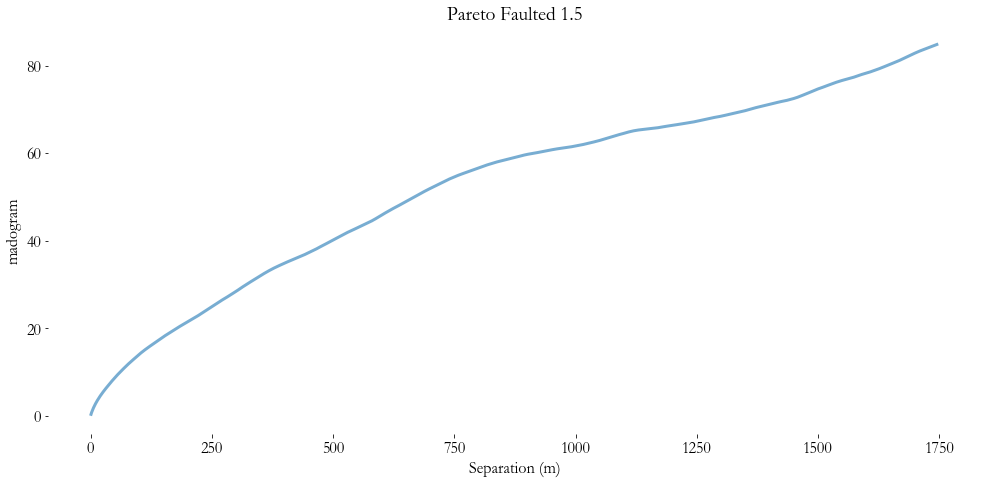

the length of the truncated madogram is 875
For Pareto Faulted 1.5:

The slope is 0.85 and intercept it -0.4. The fractal dimension is 1.15.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


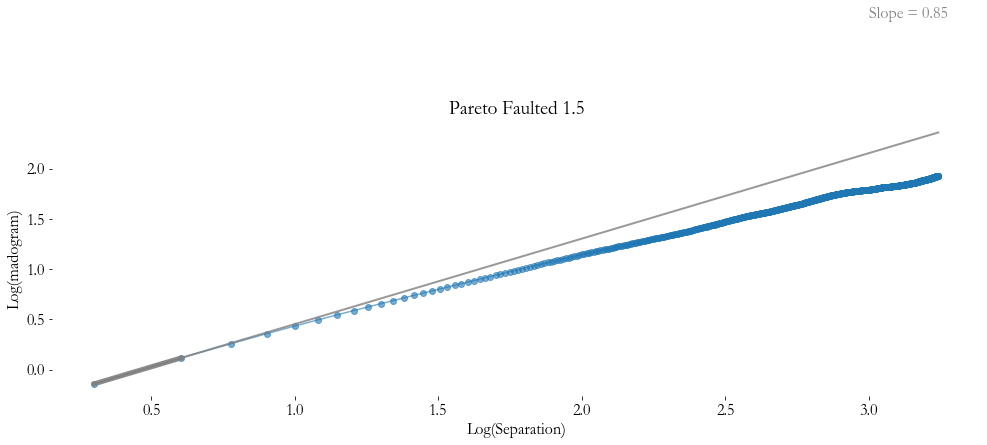

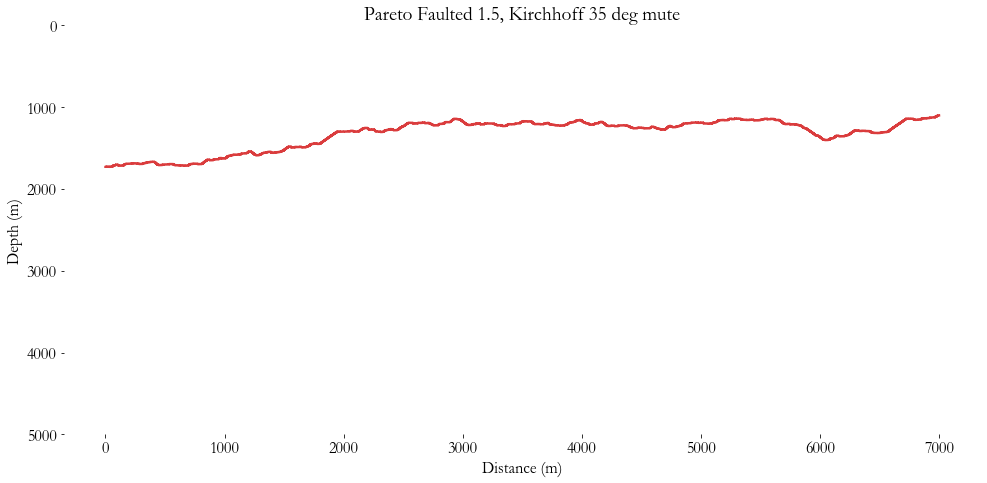

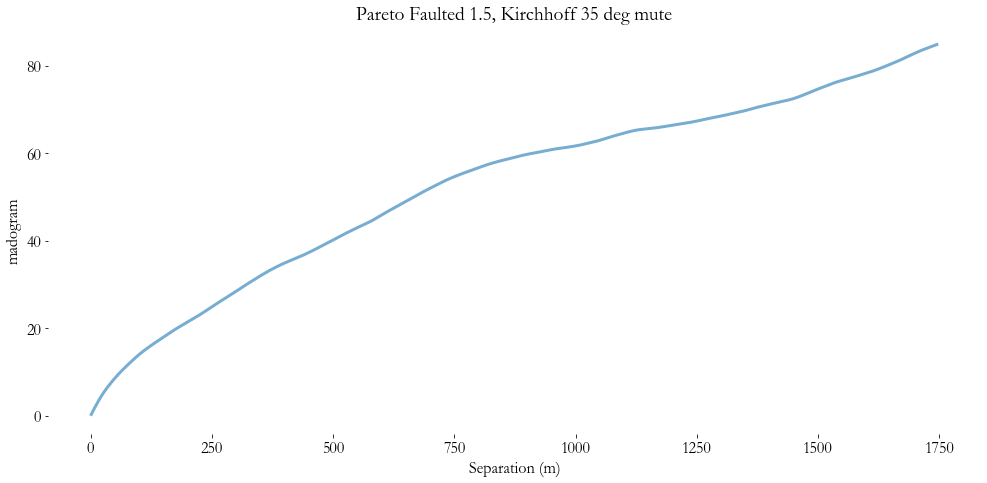

the length of the truncated madogram is 875
For Pareto Faulted 1.5, Kirchhoff 35 deg mute:

The slope is 0.98 and intercept it -0.65. The fractal dimension is 1.02.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


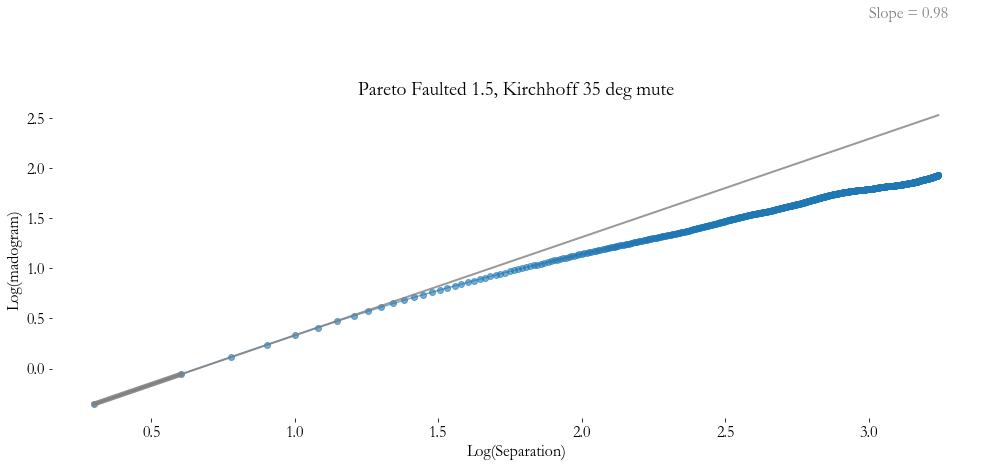

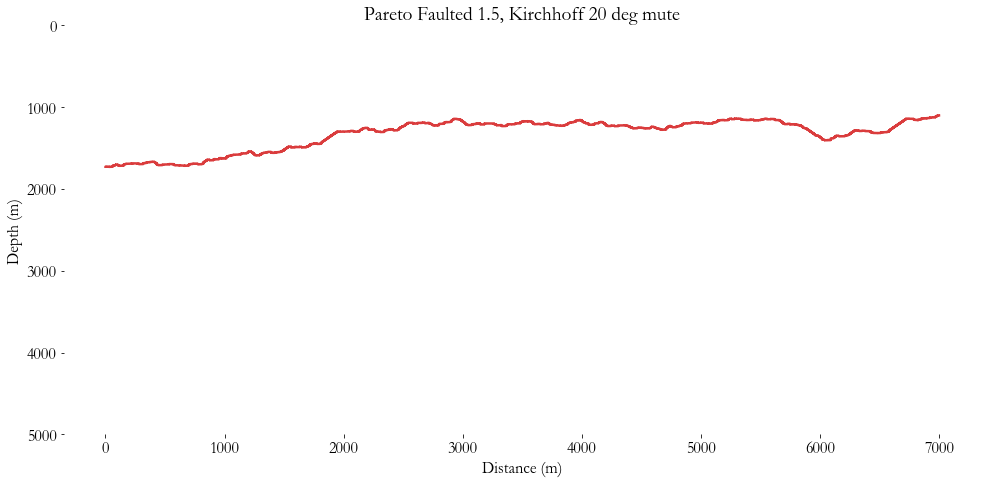

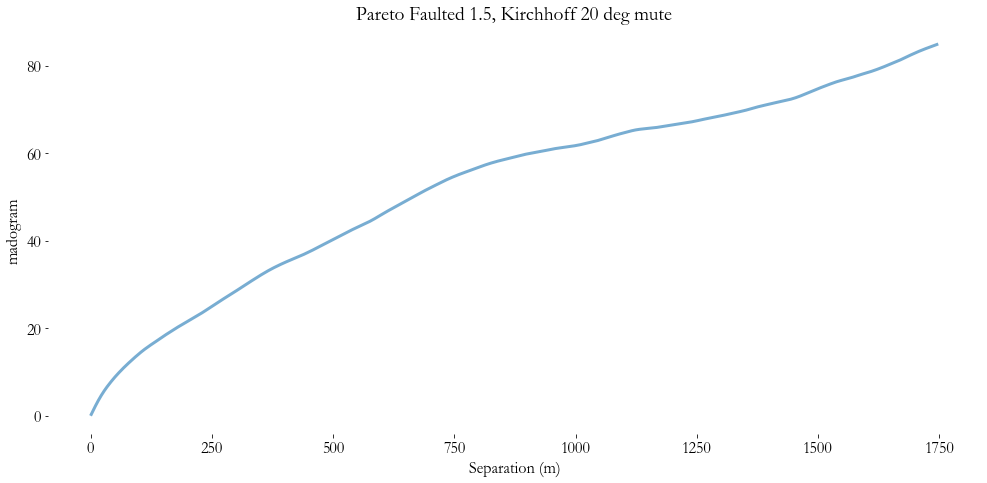

the length of the truncated madogram is 875
For Pareto Faulted 1.5, Kirchhoff 20 deg mute:

The slope is 0.99 and intercept it -0.64. The fractal dimension is 1.01.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


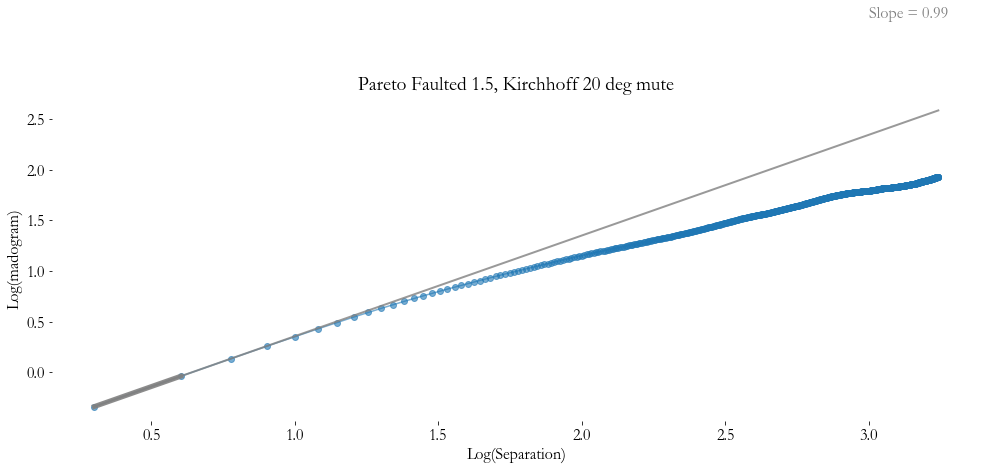

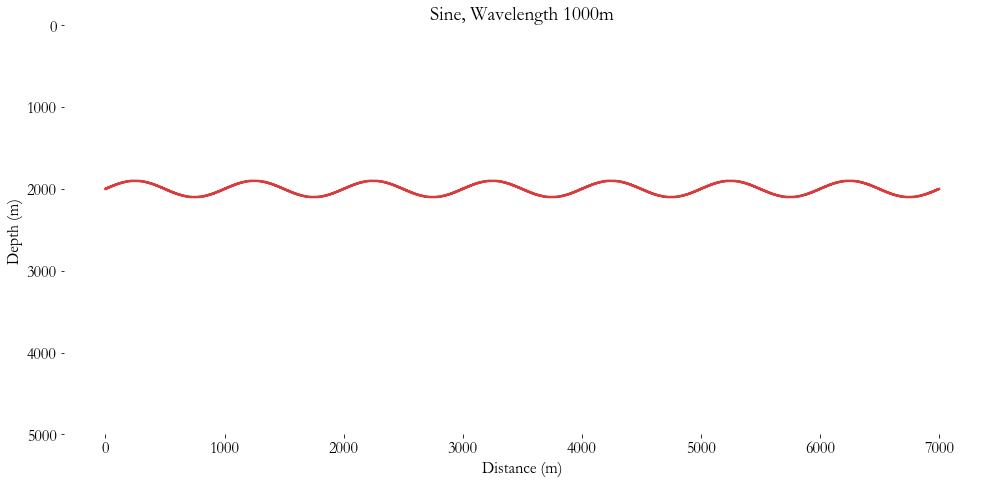

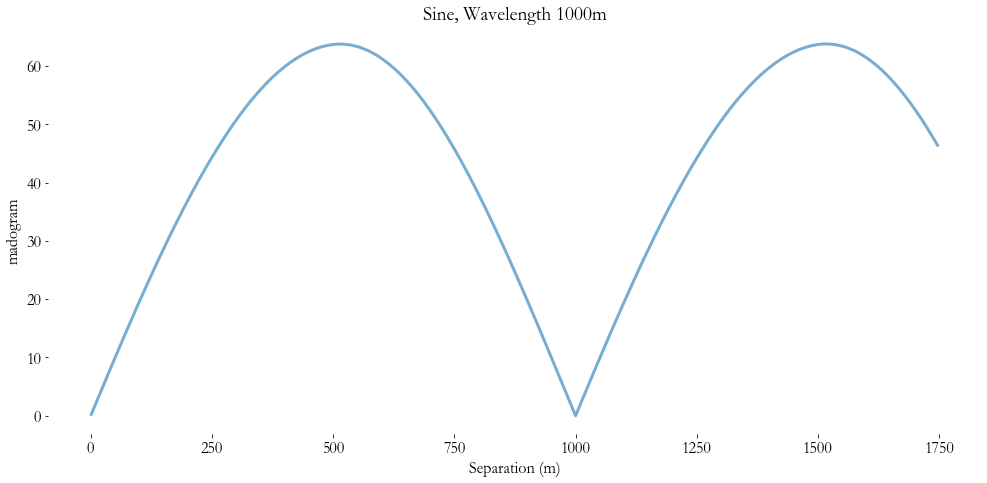

the length of the truncated madogram is 875
For Sine, Wavelength 1000m:

The slope is 1.0 and intercept it -0.7. The fractal dimension is 1.0.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


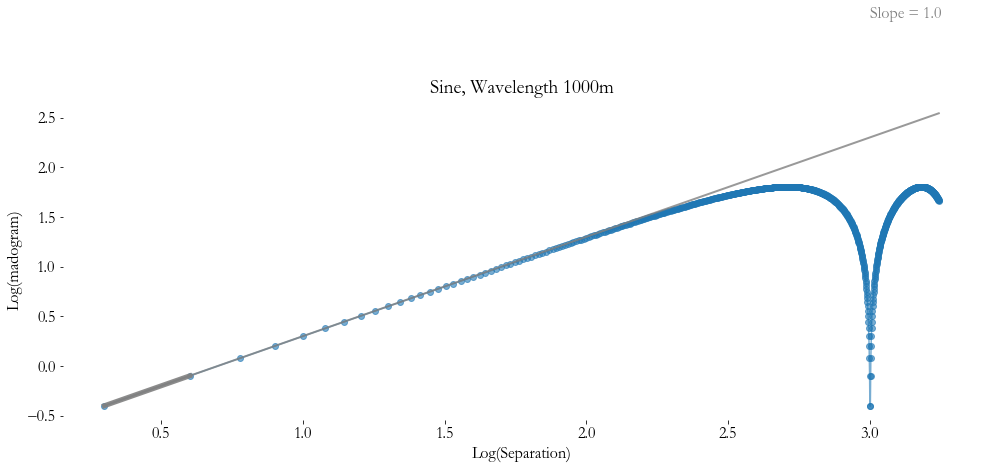

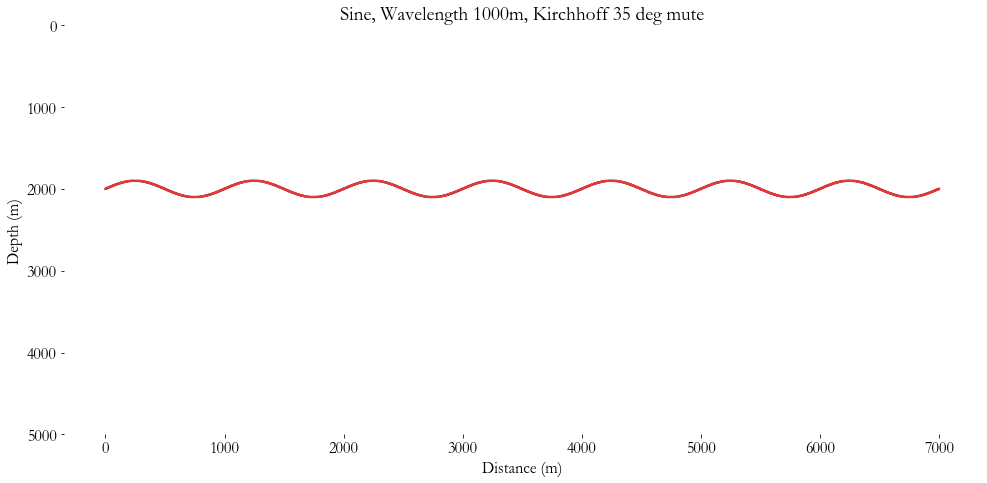

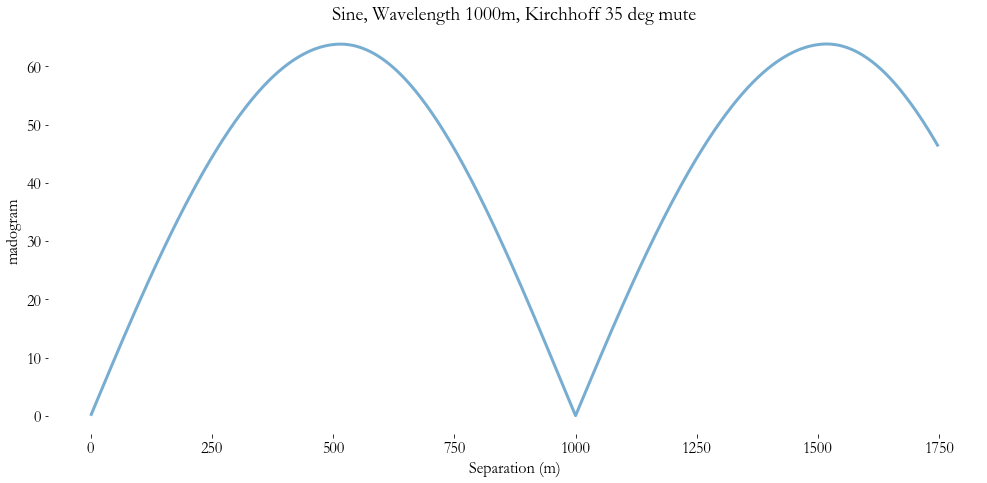

the length of the truncated madogram is 875
For Sine, Wavelength 1000m, Kirchhoff 35 deg mute:

The slope is 0.98 and intercept it -0.68. The fractal dimension is 1.02.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


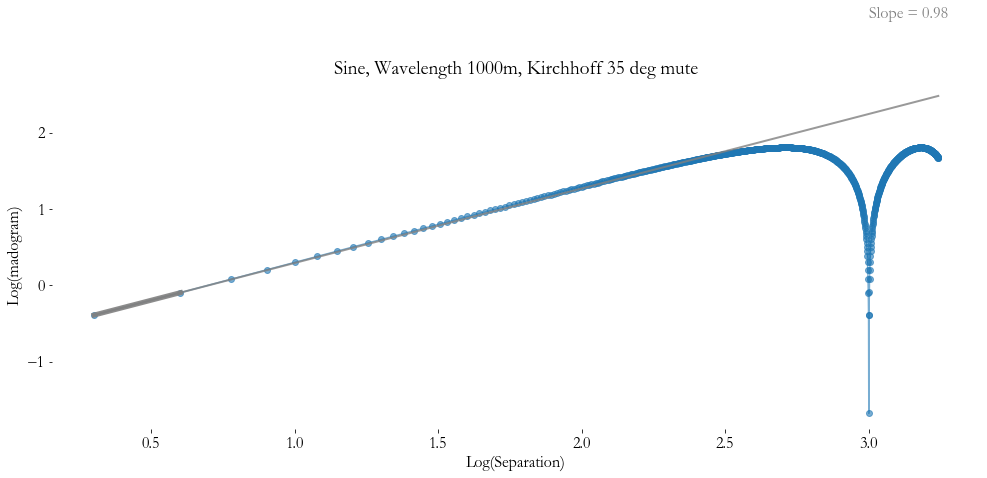

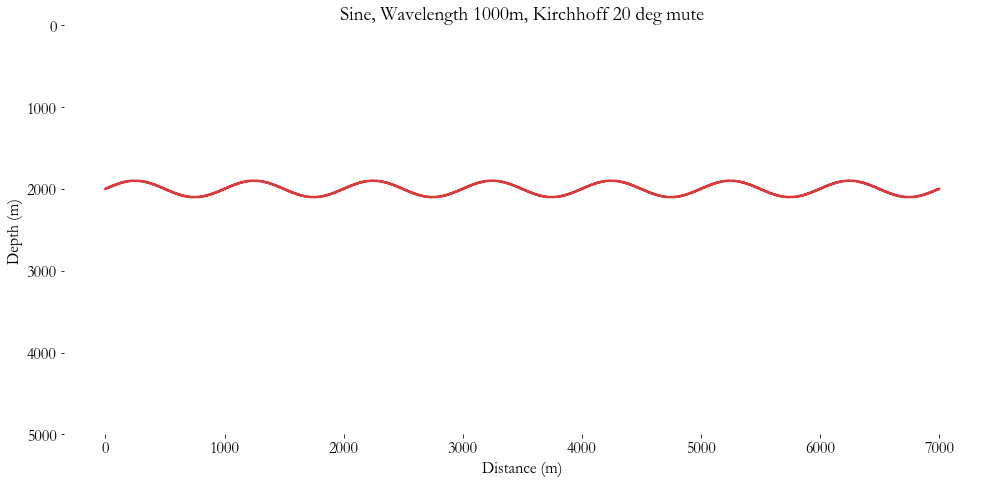

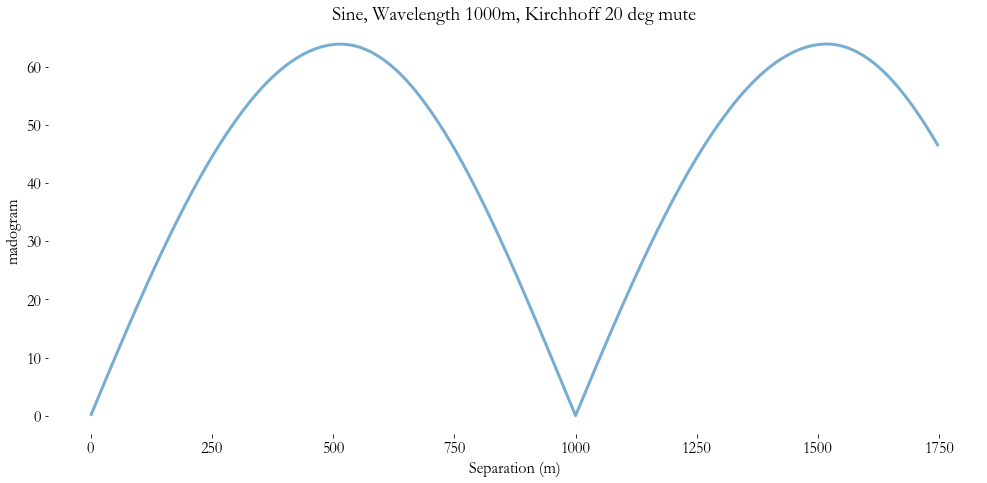

the length of the truncated madogram is 875
For Sine, Wavelength 1000m, Kirchhoff 20 deg mute:

The slope is 0.98 and intercept it -0.68. The fractal dimension is 1.02.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


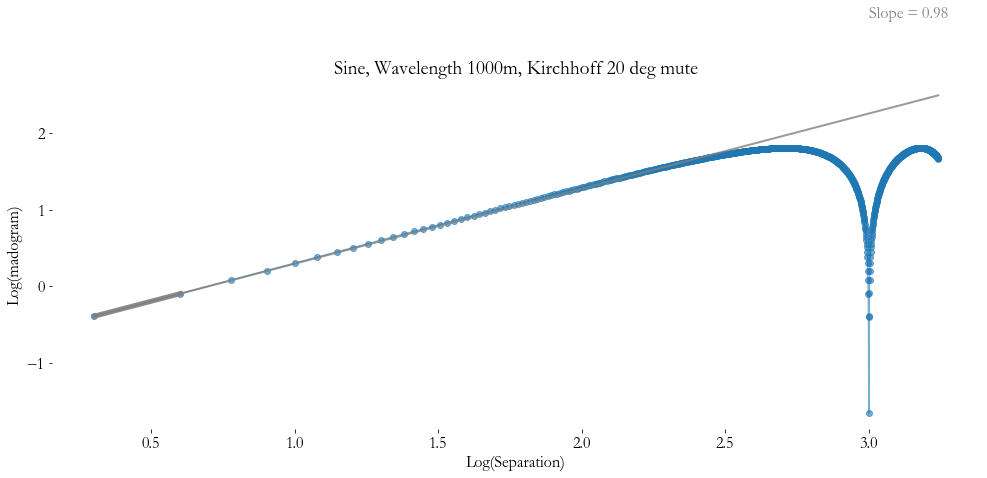

In [19]:
for i in range(len(data_list)):
    col=data_list[i][0]
    title=data_list[i][1]
    # Plot of interface
    single_plot(df_input[col].to_list(), D_total=5000, title=title, step = 2)
    # Madogram work:
    combined_gamma_plot2(df_input, depth_col=col, title=title, step=2, s_der_strt=1, s_der_fin=3, file_out=True, location=location_out_plots)

In [20]:
with open(location_out+'madogram_summary.tsv', 'a') as the_file:
    the_file.write('Title\t Slope\t Intercept\t Fractal Dimension\n')
    
    for i in range(len(data_list)):
        col=data_list[i][0]
        title=data_list[i][1]

        samples = df_input[col].to_list()
        gamma = madogram(samples)
        gamma_trunc = restrict_quarter(gamma)

        slope, intercept, frac_dim = gamma_log_slope_intercept(gamma_trunc, start=0, title=title, step=2, s_der_strt=1, s_der_fin=3)[0:3]

        res_slope = round(slope, 2)
        res_int = round(intercept, 2)
        frac_dim =round(frac_dim, 2)
    
        the_file.write(f'{title}\t {res_slope}\t {res_int}\t {frac_dim}\n')
    

For Spectral Slope 1.89:

The slope is 0.42 and intercept it 0.13. The fractal dimension is 1.58.

################################################
For Spectral Slope 1.89, Kirchhoff 35 deg mute:

The slope is 0.97 and intercept it -0.64. The fractal dimension is 1.03.

################################################
For Spectral Slope 1.89, Kirchhoff 20 deg mute:

The slope is 0.94 and intercept it -0.58. The fractal dimension is 1.06.

################################################
For Spectral Slope 1.92:

The slope is 0.41 and intercept it 0.14. The fractal dimension is 1.59.

################################################
For Spectral Slope 1.92, Kirchhoff 35 deg mute:

The slope is 0.95 and intercept it -0.61. The fractal dimension is 1.05.

################################################
For Spectral Slope 1.92, Kirchhoff 20 deg mute:

The slope is 0.94 and intercept it -0.57. The fractal dimension is 1.06.

################################################
For Pareto Fault

# Joint Plots

## Spectral slopes

In [21]:
title='Spectral Slope 1.89, Madograms'
labels = ['Spectral Slope 1.89', 'Spectral Slope 1.89, Kirchhoff 35 deg mute', 'Spectral Slope 1.89, Kirchhoff 20 deg mute']
columns = ['Spectral_slope_interface_1p89', 'Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35', 'Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = madogram(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

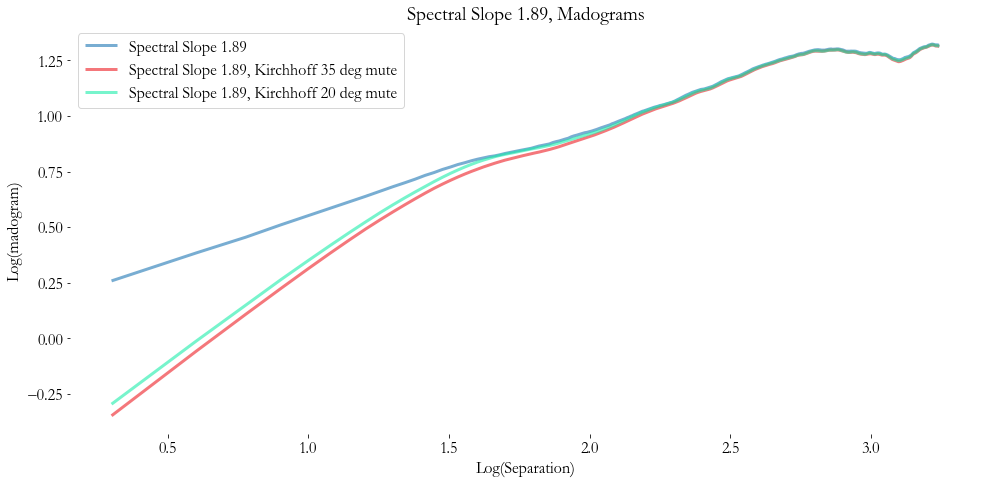

In [22]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

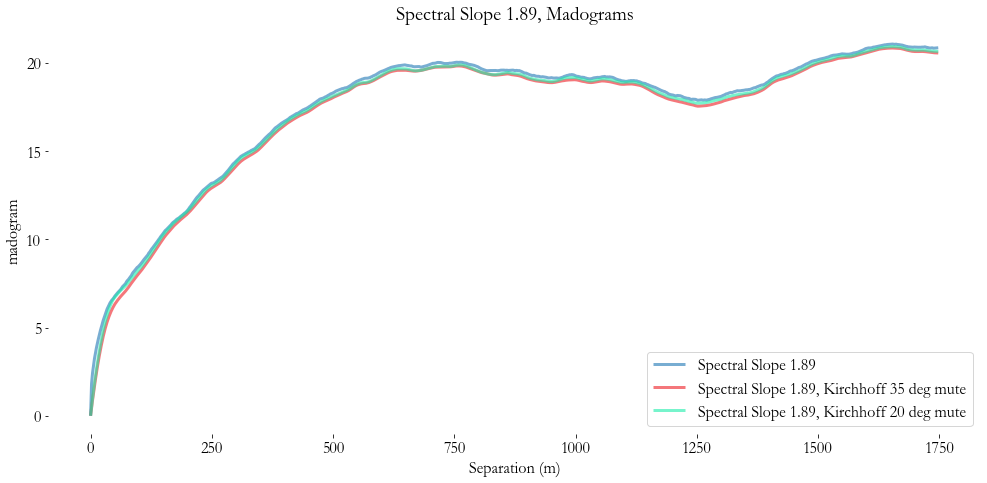

In [23]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

In [24]:
title='Spectral Slope 1.92, Madograms'
labels = ['Spectral Slope 1.92', 'Spectral Slope 1.92, Kirchhoff 35 deg mute', 'Spectral Slope 1.92, Kirchhoff 20 deg mute']
columns = ['Spectral_slope_interface_1p92', 'Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35', 'Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = madogram(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

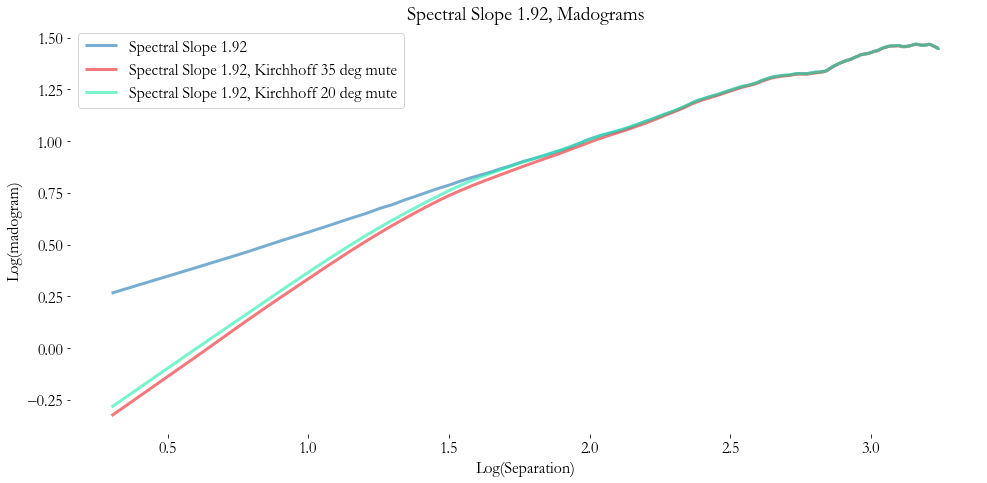

In [25]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

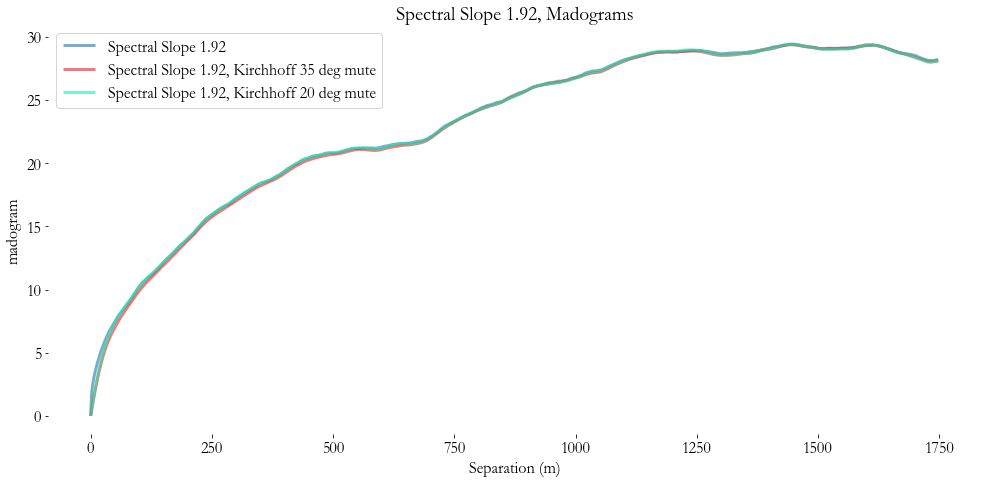

In [26]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

## Paretos

In [27]:
title='Pareto Faulted 2.0, Madograms'
labels = ['Pareto Faulted 2.0', 'Pareto Faulted 2.0, Kirchhoff 35 deg mute', 'Pareto Faulted 2.0, Kirchhoff 20 deg mute']
columns = ['Pareto_fault_interface_b_2p0', 'Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35', 'Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = madogram(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

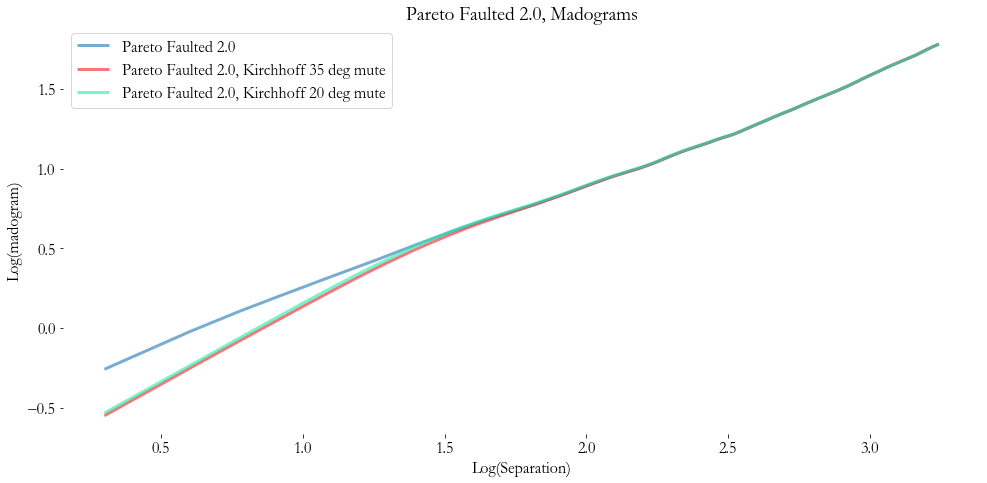

In [28]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

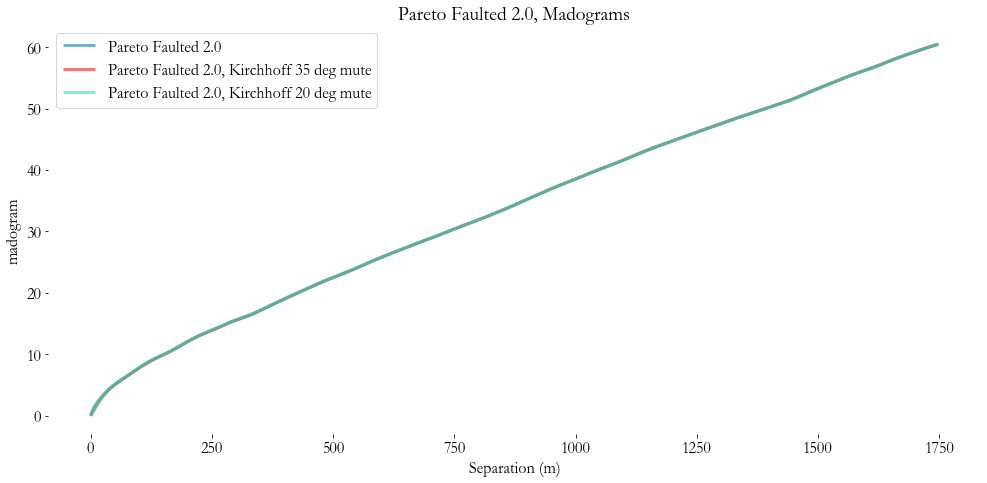

In [29]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

In [30]:
title='Pareto Faulted 1.5, Madograms'
labels = ['Pareto Faulted 1.5', 'Pareto Faulted 1.5, Kirchhoff 35 deg mute', 'Pareto Faulted 1.5, Kirchhoff 20 deg mute']
columns = ['Pareto_fault_interface_b_1p5', 'Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35', 'Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = madogram(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

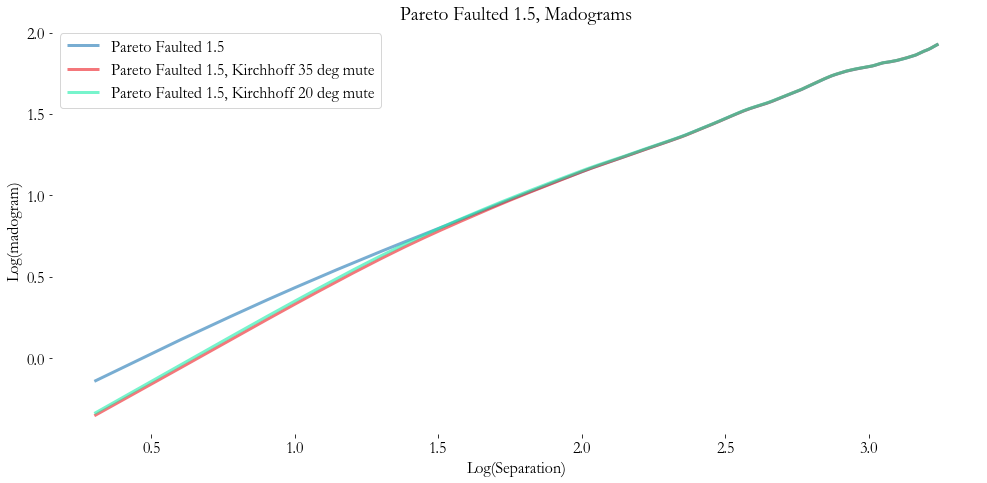

In [31]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

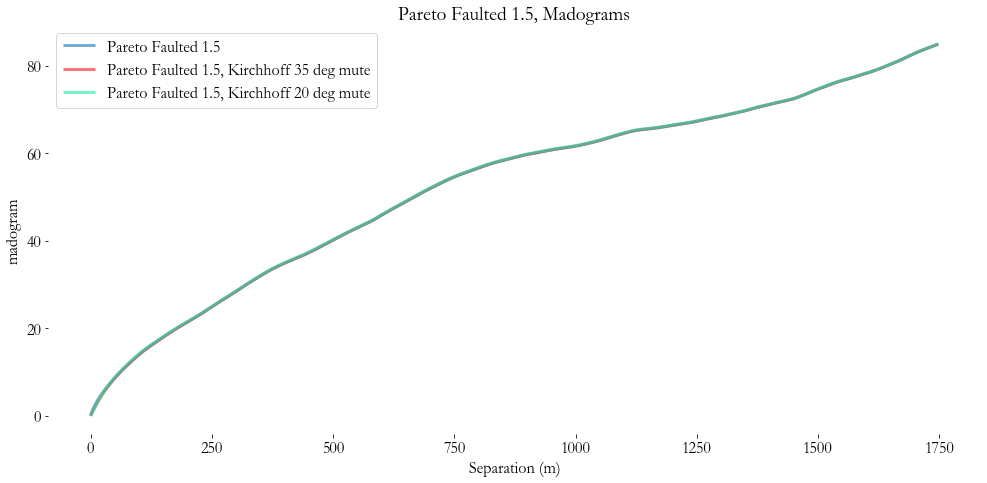

In [32]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

## Sine wave

In [33]:
title='Sine Wave, Madograms'
labels = ['Sine, Wavelength 1000m', 'Sine, Wavelength 1000m, Kirchhoff 35 deg mute', 'Sine, Wavelength 1000m, Kirchhoff 20 deg mute']
columns = ['sin1000', 'sin1000SPIRIT:T0_35,1', 'sin1000SPIRIT:T0_20,1']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = madogram(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


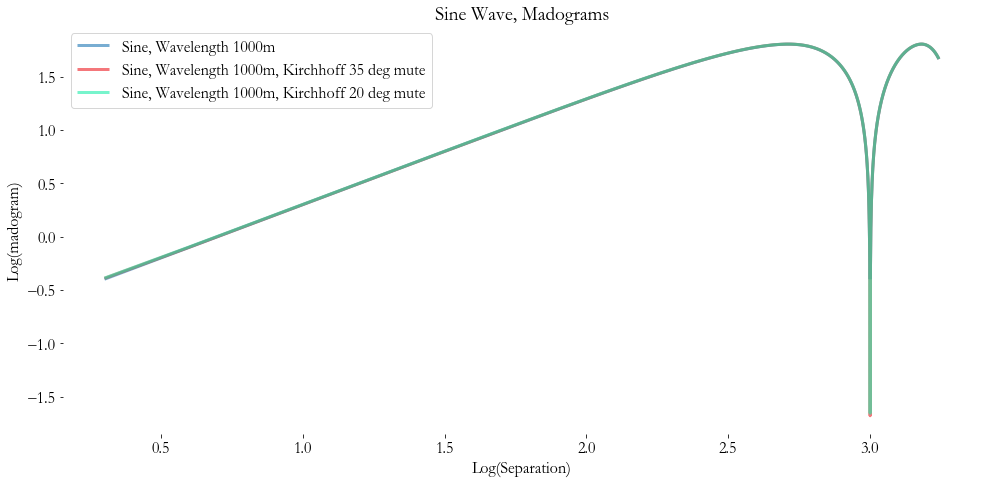

In [34]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

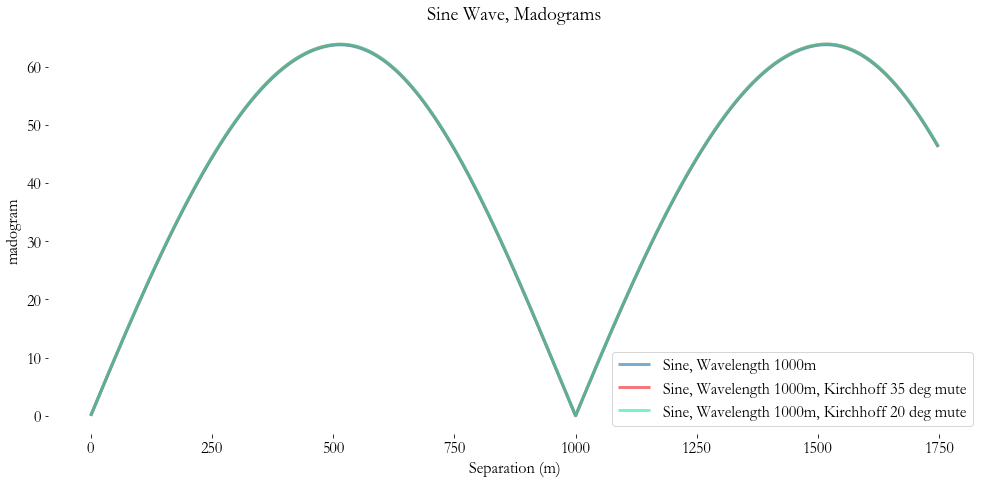

In [35]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)